In [ ]:
!pip install naima

In [1]:
import astropy.units as u
from astropy.constants import c
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = ascii.read('RXJ1713_HESS_2007.dat')
data

energy,energy_edge_lo,energy_edge_hi,flux,flux_error,ul
TeV,TeV,TeV,1 / (cm2 s TeV),1 / (cm2 s TeV),
float64,float64,float64,float64,float64,int64
0.33,0.3,0.37,2.29e-10,3.2e-11,0
0.4,0.37,0.44,1.25e-10,1.6e-11,0
0.49,0.44,0.54,9.46e-11,9e-12,0
0.59,0.54,0.65,6.06e-11,5.2e-12,0
0.71,0.65,0.79,4.37e-11,3.1e-12,0
0.86,0.79,0.95,2.15e-11,1.8e-12,0
1.04,0.95,1.15,1.82e-11,1.1e-12,0
1.26,1.15,1.39,1.17e-11,7e-13,0


In [3]:
from naima.models import ExponentialCutoffPowerLaw, PionDecay

In [4]:
def Model(pars, Es):
    """
    Define particle distribution model, radiative model, and return model flux
    at energy values
    """

    ECPL = ExponentialCutoffPowerLaw(
        pars[0] / u.eV, 10.0 * u.TeV, pars[1], 10 ** pars[2] * u.TeV
    )
    PD = PionDecay(ECPL, nh = 50 / u.cm**3)
    
    Wp = PD.compute_Wp()
    
    Ep = np.logspace(np.log10(PD.Epmin.to(u.GeV).value), 
                     np.log10(PD.Epmax.to(u.GeV).value),
                     100
                    ) * u.eV

    return PD.flux(Es, distance=1.0*u.kpc), (Ep, ECPL(Ep)), Wp

In [5]:
## Set initial parameters and labels
# Use log energy to use a uniform prior later
labels = ['amplitude_eV', 'alpha', 'log_cutoff_energy_TeV', 'nH_cm3']
p0 = np.array((2e33, 2.0, np.log10(150), 50, np.log10(1)))

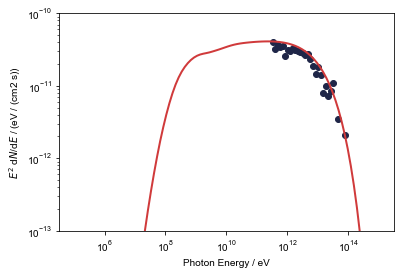

In [9]:
mask = data['ul'] == 0
plt.plot((data['energy'][mask]).to(u.eV), data['energy'][mask].to(u.erg)**2 * (data['flux'][mask]).to(1 / u.erg / u.cm**2 / u.s), 'o')

Egs = np.logspace(5, 15, 100) * u.eV
p0 = np.array((2e33, 2.0, np.log10(150), 50, np.log10(1)))
plt.plot(Egs.to(u.eV), (Egs**2 * Model(p0, Egs)[0]).to(u.erg / u.cm**2 / u.s))

plt.xlabel(f'Photon Energy / eV')
plt.ylabel(f'$E^2$ d$N$/d$E$ / (eV / (cm2 s))')

plt.xscale('log')
plt.yscale('log')

plt.ylim(1e-13,1e-10);

In [10]:
from naima import uniform_prior
from naima import run_sampler

In [11]:
labels = ['amplitude_eV', 'alpha', 'log_cutoff_energy_TeV']
p0 = np.array((1e33, 2.0, np.log10(150)))

In [12]:
def lnprior(pars):
    logprob = uniform_prior(pars[0], 1e32, 1e35) \
            + uniform_prior(pars[1], 1.5, 2.5) \
            + uniform_prior(pars[2], np.log10(10), np.log10(300))
    
    return logprob

In [25]:
## Run sampler
sampler, pos = run_sampler(
        data_table=data,
        p0=p0,
        labels=labels,
        model=Model,
        prior=lnprior,
        nwalkers=20,
        nburn=50,
        nrun=100,
        threads=4,
        prefit=True,
        interactive=False,
    )

INFO: Finding Maximum Likelihood parameters through Nelder-Mead fitting... [naima.core]
INFO:    Initial parameters: [1.71876662e+33 2.00000000e+00 2.17609126e+00] [naima.core]
INFO:    Initial lnprob(p0): -19.078 [naima.core]
INFO:    New ML parameters : [1.72543028e+33 1.90059987e+00 2.04670210e+00] [naima.core]
INFO:    Maximum lnprob(p0): -17.717 [naima.core]
Burning in the 20 walkers with 50 steps...

Progress of the run: 0 percent (0 of 50 steps)
                           -amplitude_eV-- -----alpha----- log_cutoff_energy_TeV
  Last ensemble median :    1.73e+33           1.9            2.04      
  Last ensemble std    :    1.57e+31         0.0136          0.0151     
  Last ensemble lnprob :  avg: -18.384, max: -17.725

Progress of the run: 10 percent (5 of 50 steps)
                           -amplitude_eV-- -----alpha----- log_cutoff_energy_TeV
  Last ensemble median :    1.73e+33           1.9            2.05      
  Last ensemble std    :    2.51e+31         0.0356         


Progress of the run: 70 percent (70 of 100 steps)
                           -amplitude_eV-- -----alpha----- log_cutoff_energy_TeV
  Last ensemble median :    1.71e+33          1.89            2.03      
  Last ensemble std    :    8.46e+31         0.0979           0.127     
  Last ensemble lnprob :  avg: -19.434, max: -18.117

Progress of the run: 75 percent (75 of 100 steps)
                           -amplitude_eV-- -----alpha----- log_cutoff_energy_TeV
  Last ensemble median :    1.75e+33          1.91            2.03      
  Last ensemble std    :    9.54e+31         0.0985           0.133     
  Last ensemble lnprob :  avg: -19.799, max: -18.058

Progress of the run: 80 percent (80 of 100 steps)
                           -amplitude_eV-- -----alpha----- log_cutoff_energy_TeV
  Last ensemble median :    1.73e+33          1.89            2.04      
  Last ensemble std    :    1.13e+32         0.0973           0.148     
  Last ensemble lnprob :  avg: -19.708, max: -18.189

Progre

In [26]:
from naima import plot_corner, plot_chain, plot_fit

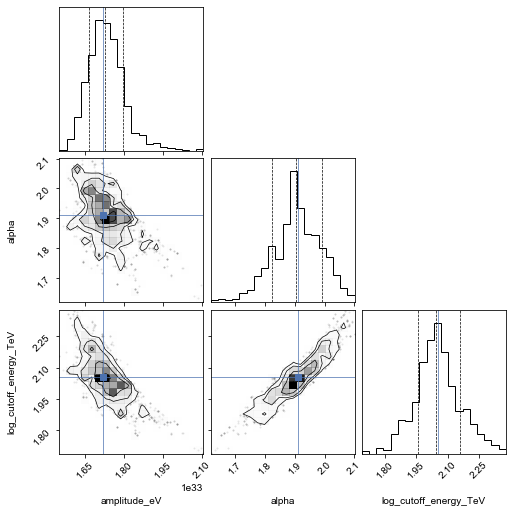

In [29]:
plot_corner(sampler)
plt.savefig('naima-corner.pdf')

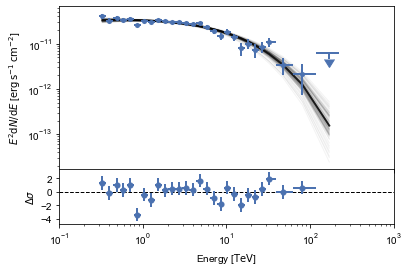

In [30]:
plot_fit(sampler)
plt.savefig('naima-models.pdf')

INFO: -------------------amplitude_eV-------------------
          amplitude_eV = $(1.73 \pm 0.06)\times10^{33}$ [naima.plot]
INFO: ----------------------alpha-----------------------
          alpha = $1.90 \pm 0.08$ [naima.plot]
INFO: --------------log_cutoff_energy_TeV---------------
          log_cutoff_energy_TeV = $2.05^{+0.12}_{-0.09}$ [naima.plot]


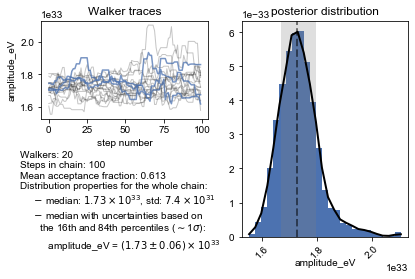

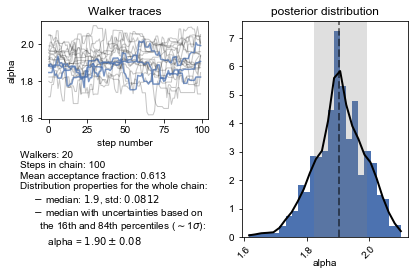

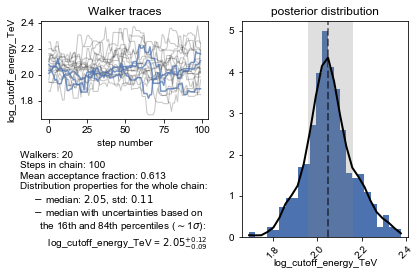

In [31]:
plot_chain(sampler)
plt.savefig('naima-walkers.pdf')